In [1]:
#import gymnasium as gym
import gym
from gym.wrappers import FrameStack
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from pathlib import Path

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from gym.spaces import Box
from torchvision import transforms
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage
from tensordict import TensorDict
import cv2

In [2]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
from ale_py import ALEInterface

ale = ALEInterface()

from ale_py.roms import SpaceInvaders
ale.loadROM(SpaceInvaders)

In [4]:
# env = gym.make("ALE/SpaceInvaders-v5", render_mode="human")
# print("action: ", env.action_space.n, env.unwrapped.get_action_meanings())
# live = True
# env.reset()
# for i in range(100):
#     action = env.action_space.sample()
#     observation, reward, terminated, truncated, info = env.step(action)
#     print("Step: ", i, ", Observation:", observation.shape, ", Reward:", reward, ", Terminated and Truncated:", terminated, truncated, ", Info:", info, end="\r")
#     done = terminated or truncated
#     if done:
#         env.reset()
# env.close() 

In [5]:
# plt.imshow(observation)
# plt.savefig("space_invaders.png")

In [6]:
# fig_obser = observation.copy()

In [7]:
# print("Observation shape: ", fig_obser.shape)
# plt.imshow(fig_obser)

In [8]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = transforms.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape_H, shape_W):
        super().__init__(env)
        if (isinstance(shape_H, int) and isinstance(shape_H, int)):
            self.shape = (shape_H, shape_W)
        else:
            self.shape = tuple(shape_H, shape_W)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms_data = transforms.Compose(
            [transforms.Resize(self.shape, antialias=True), transforms.Normalize(0, 255)]
        )
        observation = transforms_data(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = gym.make("SpaceInvaders-v4", render_mode="rgb_array")
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape_H=84, shape_W=64)
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)

In [9]:
# env.reset()

In [10]:
# for i in range(10):
#     observation, reward, terminated, truncated, info = env.step(1)
# print("Step: ", i, ", Observation:", observation.shape, ", Reward:", reward, ", Terminated and Truncated:", terminated, truncated, ", Info:", info, end="\r")

In [11]:
# fig_obser = observation
# print("Observation shape: ", fig_obser._frames[0])
# fig, ax = plt.subplots(1, 4, figsize=(12, 12))
# for i in range(4):
#     ax[i].imshow(fig_obser._frames[i])

In [12]:
class SINet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 64:
            raise ValueError(f"Expecting input width: 64, got: {w}")

        self.online = self.__build_cnn(c, output_dim)

        self.target = self.__build_cnn(c, output_dim)
        self.target.load_state_dict(self.online.state_dict())

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

    def __build_cnn(self, c, output_dim):
        return nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1792, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

In [13]:
class SI:
    def __init__(self, state_dim, action_dim, save_dir):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        self.net = SINet(self.state_dim, self.action_dim).float()
        self.net = self.net.to(device=self.device)

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 5e5  # no. of experiences between saving Mario Net
        
        self.memory = TensorDictReplayBuffer(storage=LazyMemmapStorage(100000, device=torch.device("cpu")))
        self.batch_size = 32
        
        self.gamma = 0.9
        
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()
        
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def act(self, state):
        """
        Given a state, choose an epsilon-greedy action and update value of step.

        Inputs:
        state(``LazyFrame``): A single observation of the current state, dimension is (state_dim)
        
        Outputs:
        ``action_idx`` (``int``): An integer representing which action Mario will perform
        """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            # Maybe this place should add random noise
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (``LazyFrame``),
        next_state (``LazyFrame``),
        action (``int``),
        reward (``float``),
        done(``bool``))
        """
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()

        state = torch.tensor(state)
        next_state = torch.tensor(next_state)
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        done = torch.tensor([done])

        # self.memory.append((state, next_state, action, reward, done,))
        self.memory.add(TensorDict({"state": state, "next_state": next_state, "action": action, "reward": reward, "done": done}, batch_size=[]))

    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = self.memory.sample(self.batch_size).to(self.device)
        state, next_state, action, reward, done = (batch.get(key) for key in ("state", "next_state", "action", "reward", "done"))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)
    
    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()
    
    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())
        
    def save(self):
        save_path = (
            self.save_dir / f"mario_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"MarioNet saved to {save_path} at step {self.curr_step}")

In [14]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f"{metric}_plot"))

Using CUDA: True



c:\Users\K505\.conda\envs\RL\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0 - Step 208 - Epsilon 0.9999480013454696 - Mean Reward 225.0 - Mean Length 208.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 0.484 - Time 2024-06-02T17:44:03
Episode 20 - Step 3669 - Epsilon 0.9990831704305106 - Mean Reward 154.524 - Mean Length 174.714 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 10.214 - Time 2024-06-02T17:44:14
Episode 40 - Step 7129 - Epsilon 0.9982193370417894 - Mean Reward 141.341 - Mean Length 173.878 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 7.657 - Time 2024-06-02T17:44:21
Episode 60 - Step 10829 - Epsilon 0.9972964109586496 - Mean Reward 147.295 - Mean Length 177.525 - Mean Loss 0.082 - Mean Q Value 0.005 - Time Delta 10.334 - Time 2024-06-02T17:44:32
Episode 80 - Step 14805 - Epsilon 0.996305590721404 - Mean Reward 158.333 - Mean Length 182.778 - Mean Loss 0.25 - Mean Q Value 0.016 - Time Delta 18.053 - Time 2024-06-02T17:44:50
Episode 99 - Step 17631 - Epsilon 0.9956019493240981 - Mean Reward 145.45 - Mean Length 176.31 - Mean Loss 0.3

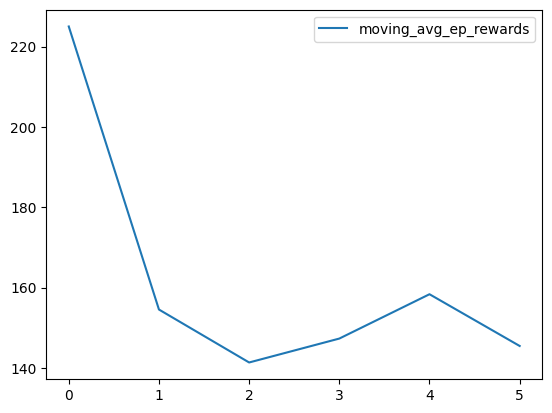

In [15]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

spaceinvader = SI(state_dim=(4, 84, 64), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 100
for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:

        # Run agent on the state
        action = spaceinvader.act(state)

        # Agent performs action
        next_state, reward, done, trunc, info = env.step(action)

        # Remember
        spaceinvader.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = spaceinvader.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done:
            break

    logger.log_episode()

    if (e % 20 == 0) or (e == episodes - 1):
        logger.record(episode=e, epsilon=spaceinvader.exploration_rate, step=spaceinvader.curr_step)

In [22]:
env = gym.make("SpaceInvaders-v4", render_mode="rgb_array")
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape_H=84, shape_W=64)
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)
#print("action: ", env.action_space.n, env.unwrapped.get_action_meanings())

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

spaceinvader = SI(state_dim=(4, 84, 64), action_dim=env.action_space.n, save_dir=save_dir)
checkpoint = torch.load(".mario_net_44.chkpt")
spaceinvader.net.load_state_dict(checkpoint["model"])
spaceinvader.exploration_rate = checkpoint["exploration_rate"]

live = True
state, _ = env.reset()
reward_tot = 0
i = 0

while live:
    action = spaceinvader.act(state)
    next_state, reward, done, trunc, info = env.step(action)
    frame = state._frames[0].cpu().numpy()
    frame = cv2.resize(frame, (320, 420))
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) == ord('q'):
        break
    reward_tot += reward
    print("Step: ", i, ", Observation:", next_state.shape, ", Reward:", reward, ", Reward_tot:", reward_tot, ", Terminated and Truncated:", done, ", Info:", info, end="\r")
    live = not(done)
    state = next_state
    i += 1
env.close()
cv2.destroyAllWindows()

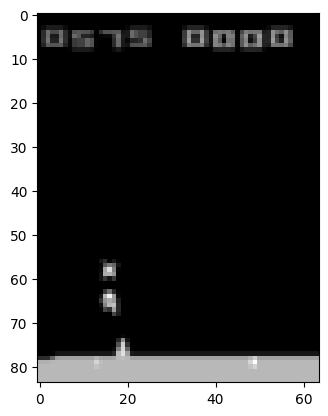

In [23]:
plt.imshow(state[0], cmap='gray')
plt.savefig("space_invaders2.png")